# Module 6: Generalization Performance 

* Consider our original regression dataset in the Figure below

* We can fit simple polynomial functions with various degrees to this dataset. We'll pick degree = 1 (blue), 5 (purple), and 15 (magenta).

$$\hat{y}(x)=\beta_{0}+\beta_{1}x+...+\beta_{n}x^{n}$$

* The higher the degree of the polynomial, the more parameters, and hence, the more complex the model

![alt text](figures/generalization_training.png)


* Clearly, as the degree increases, the MSE on the dataset decreases.

* But, look at what happens when we measure MSE on data points the model has not been trained on:

![alt text](figures/generalization_testing.png)

* The most complex model has the worst MSE on unseen data, despite having the best MSE on the training data

* We say that the model has _overfitted_ to the training dataset: it mistook noise for an actual signal.

* This is why we _must_ evaluate our models on data the model has not been trained on

## Tracking Training and Testing Performance

* Before we do that, lets see how our neural network models can overfit. 

* We'll take this opportuntiy to introduce a high-level framework called Keras. Keras sits on top of tensorflow and makes building, training, and running common neural networks much easier.

* We'll withhold 20% of the data for testing and plot how the loss on training and testing changes over time.


In [1]:
# necessary imports
import numpy as np
import numpy.random as rng 
import tensorflow as tf
import matplotlib.pyplot as plt 
import sklearn.metrics
import keras.layers as layers
import keras.models
import scipy.stats
import keras.utils

Using TensorFlow backend.


In [2]:
# read and shuffle data from our binary classification example
data = np.load('data/multiclass_classification_hard.npz')
X, y = data['X'], data['y']
ix = rng.permutation(X.shape[0])
X = X[ix, :]
y = keras.utils.to_categorical(y[ix, :])

In [3]:
# number of hidden units
n_hidden = 30

# notice that we don't specify the first dimension in the input 
# shape, Keras infers that automatically
# the trailing comma is important! don't forget it
input_node = layers.Input(shape=(X.shape[1],))
hidden_layer = layers.Dense(n_hidden, activation='tanh')(input_node)
output_node = layers.Dense(y.shape[1], activation='softmax')(hidden_layer)
model = keras.models.Model(inputs=input_node, outputs=output_node)
model.compile('sgd', 'categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 186       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
# train the model
h = model.fit(x = X, y=y, verbose=False, validation_split=0.2, epochs=2000, batch_size=100)

(0, 0.6)

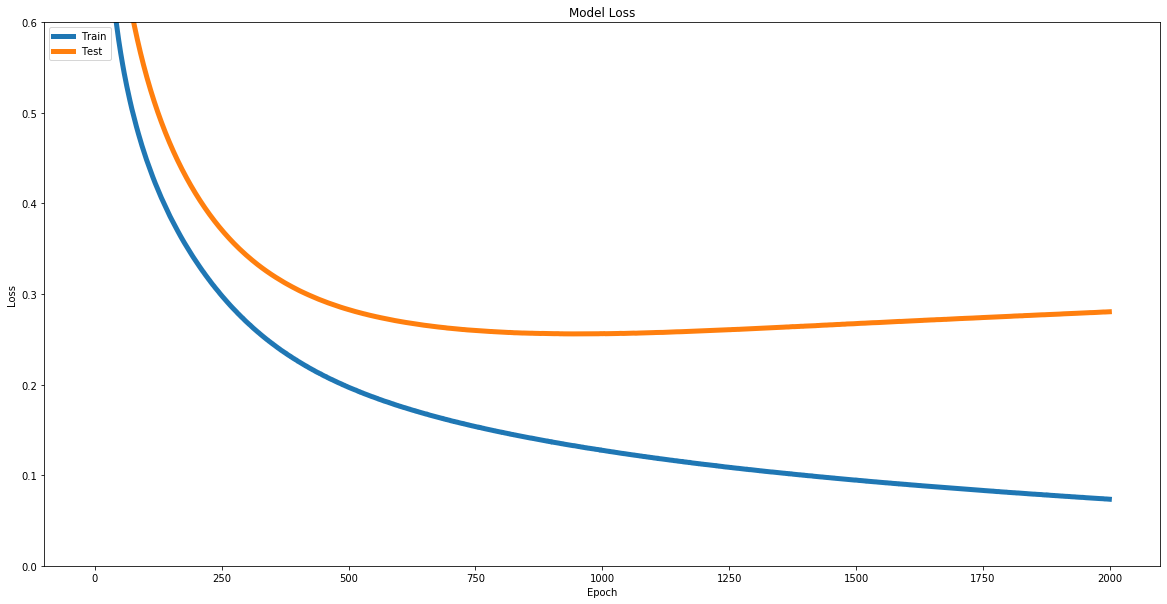

In [5]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(h.history['loss'], linewidth=5)
ax.plot(h.history['val_loss'], linewidth=5)
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
ax.set_ylim([0, 0.6])

(0.8, 1.0)

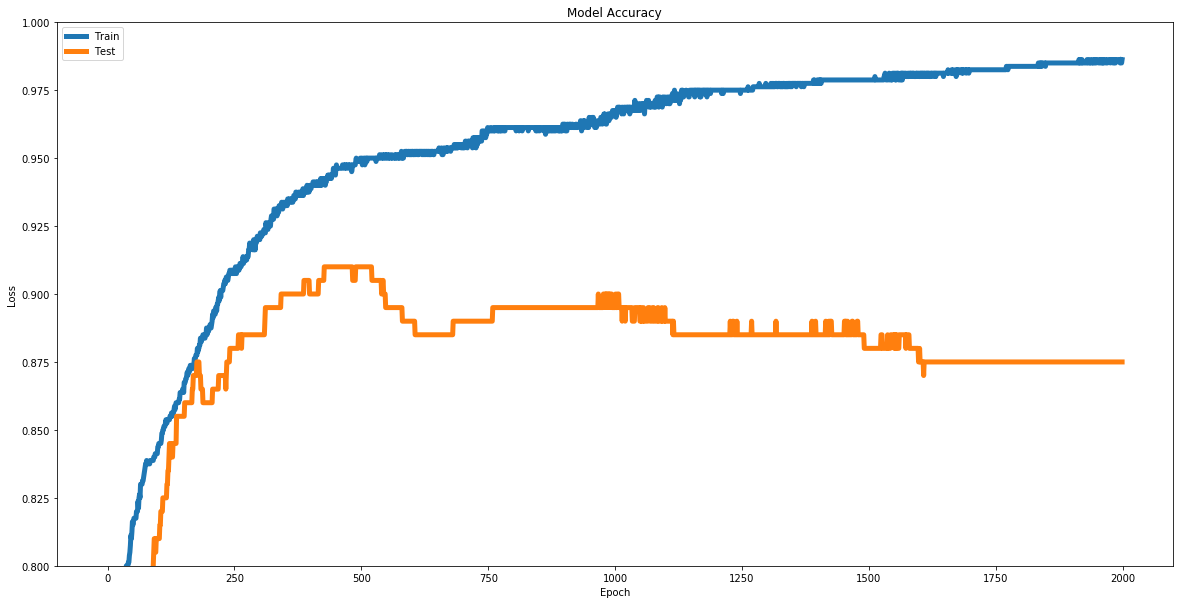

In [6]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(h.history['acc'], linewidth=5)
ax.plot(h.history['val_acc'], linewidth=5)
ax.set_title('Model Accuracy')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
ax.set_ylim([0.8, 1.0])

## Fighting Overfitting: Dropout

* With dropout, neurons are randomly "turned-off" with some probability $p$.
* The theory behind dropout is that it encourages neurons to specialize and not rely on other neurons
* Special care has to be taken when using dropout because it changes the expect value of the output of the neurons
* Fortunately, Keras takes care of this detail for us
* Let's add dropout to our earlier example

### How Can you Differentiate Randomness?

* You may wonder how can one do calculus when random operations are involved. The answer is that random number generators are not truly-random, they are _pseudo_-random number generators.


In [7]:
# number of hidden units
n_hidden = 30
dropout_p = 0.5

input_node = layers.Input(shape=(X.shape[1],))
hidden_layer = layers.Dense(n_hidden, activation='tanh')(input_node)
hidden_layer = layers.Dropout(rate=dropout_p)(hidden_layer)
output_node = layers.Dense(y.shape[1], activation='softmax')(hidden_layer)
model = keras.models.Model(inputs=input_node, outputs=output_node)
model.compile('sgd', 'categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 186       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# train the model
h = model.fit(x = X, y=y, verbose=False, validation_split=0.2, epochs=2000, batch_size=100)

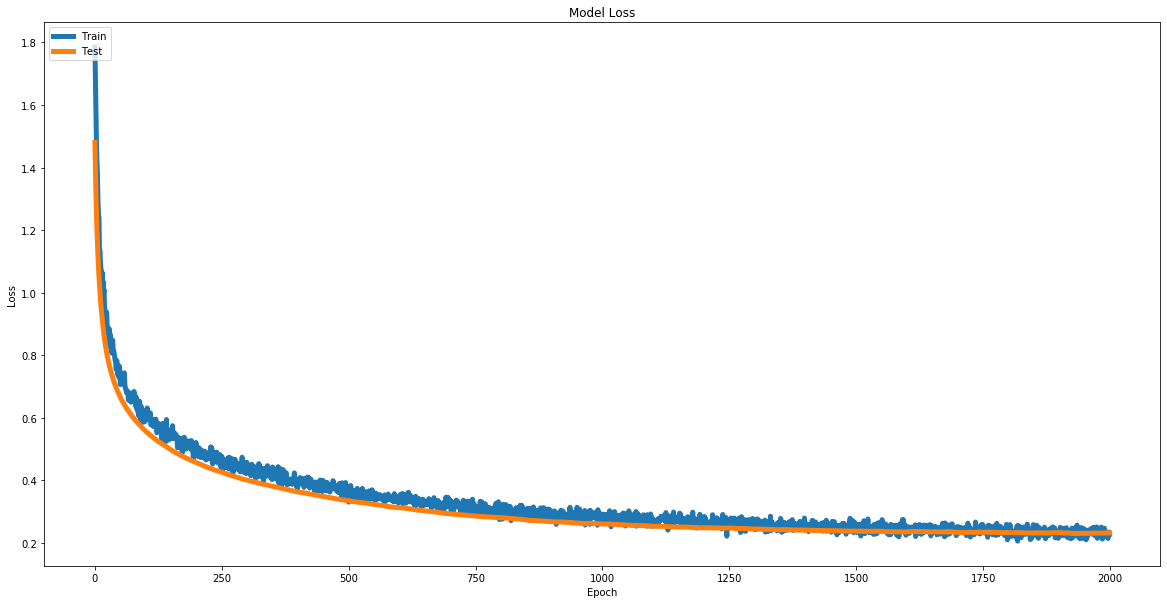

In [9]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(h.history['loss'], linewidth=5)
ax.plot(h.history['val_loss'], linewidth=5)
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

(0.8, 1.0)

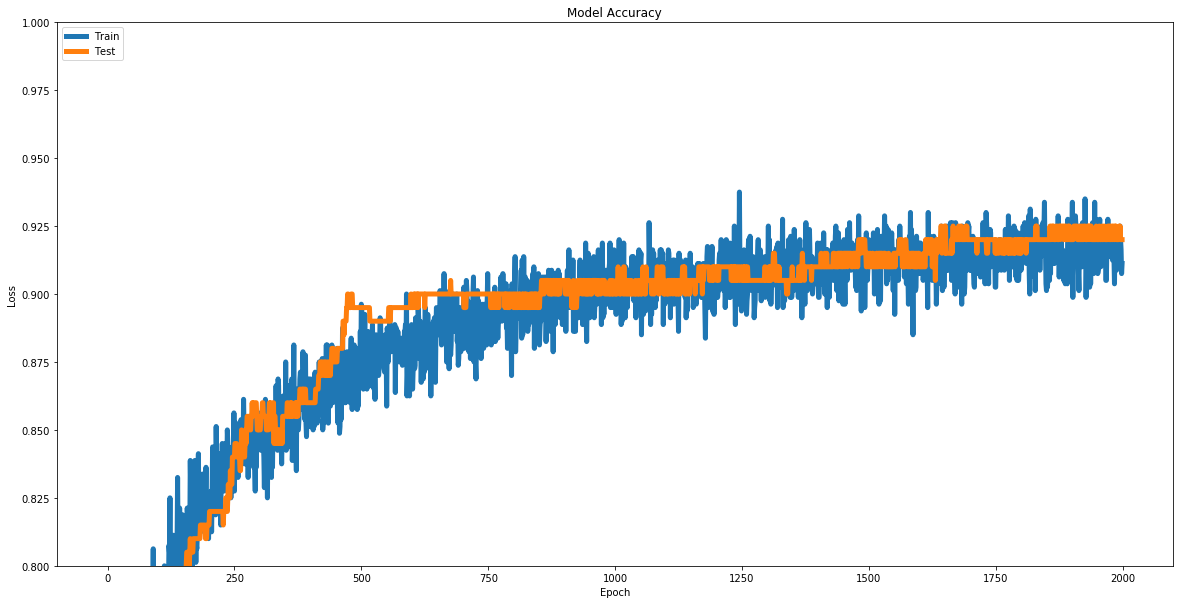

In [10]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(h.history['acc'], linewidth=5)
ax.plot(h.history['val_acc'], linewidth=5)
ax.set_title('Model Accuracy')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
ax.set_ylim([0.8, 1.0])

## Fighting Overfitting: Regularization

* An extra term is a added to the loss function to penalize network weights that are too large. For example, the common L2 regularization scheme adds a summation of all network weights squared:

$$\mathcal{L}(\hat{y}_{i},y_{i})=\mathcal{L}_{MSE}(\hat{y}_{i},y_{i})+0.5\lambda\sum_{j}w_{j}^{2}$$

* L2 regularization encourages diffuse weight vectors and discourages vectors with large individual weights

* The regularization parameter $\lambda$ has to be determined ahead of time

In [11]:
import keras.regularizers as reg 

# number of hidden units
n_hidden = 30

# L2 regularization penalty term, try different values [0.001, 0.01, 0.1, 1.]
l2_penalty = 0.05


# notice that we don't specify the first dimension in the input 
# shape, Keras infers that automatically
# the trailing comma is important! don't forget it
input_node = layers.Input(shape=(X.shape[1],))
hidden_layer = layers.Dense(n_hidden, activation='tanh', kernel_regularizer=reg.l2(l2_penalty))(input_node)
output_node = layers.Dense(y.shape[1], activation='softmax', kernel_regularizer=reg.l2(l2_penalty))(hidden_layer)
model = keras.models.Model(inputs=input_node, outputs=output_node)
model.compile('sgd', 'categorical_crossentropy', metrics=['acc'])
print(model.summary())


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 186       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# train the model
h = model.fit(x = X, y=y, verbose=False, validation_split=0.2, epochs=2000, batch_size=100)

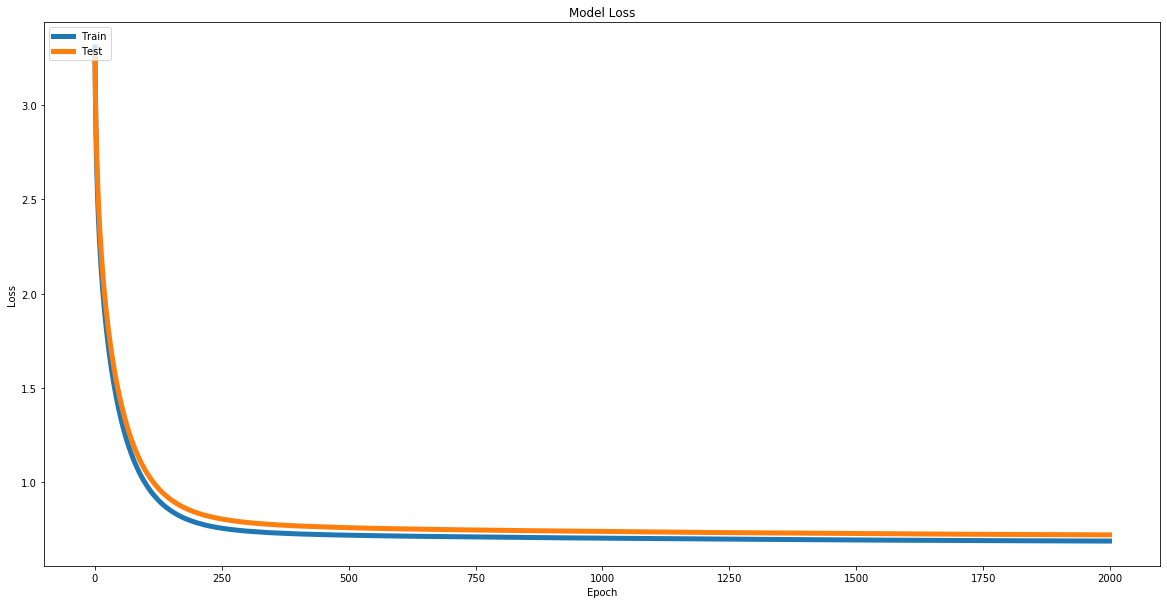

In [13]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(h.history['loss'], linewidth=5)
ax.plot(h.history['val_loss'], linewidth=5)
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

0.925000011920929


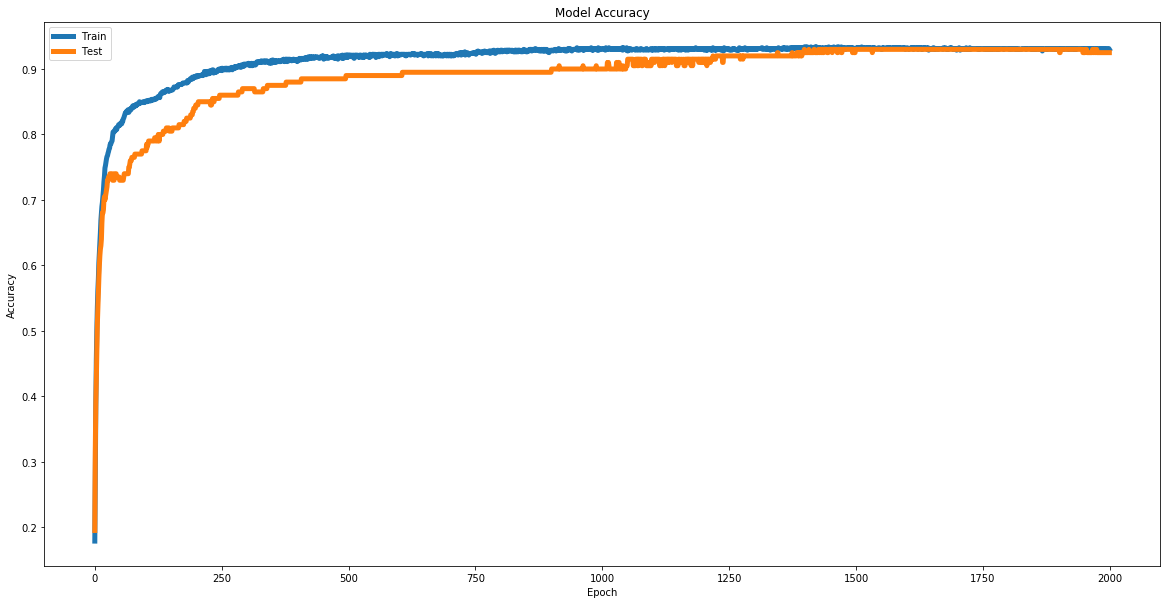

In [14]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(h.history['acc'], linewidth=5)
ax.plot(h.history['val_acc'], linewidth=5)
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')
print(h.history['val_acc'][-1])

## Fighting Overfitting: Early-Stopping

* Why don't we just run the model, and pick the point at which the test loss stops decreasing?

* That's a huge NO NO. By doing so, you are implicitly training on the test set, even though you are not applying gradient descent directly to it.

* But, this does provide us with an idea: what if we split the training set further into a _real_ training set and a validation set.

* We train the model on the real training set and monitor the loss on the validation set. And pick the model with the lowest validation error.

* To do this with Keras, we use the concept of _callbacks_. 

* A callback is a function that gets called at the end of every epoch.

* We need two callbacks: one to stop training when the validation loss starts increasing, and one to save the model parameter at that point.

In [15]:
import keras.callbacks

In [16]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

In [17]:
# number of hidden units
n_hidden = 30


# build model
input_node = layers.Input(shape=(X.shape[1],))
hidden_layer = layers.Dense(n_hidden, activation='tanh')(input_node)
output_node = layers.Dense(y.shape[1], activation='softmax')(hidden_layer)
model = keras.models.Model(inputs=input_node, outputs=output_node)
model.compile('sgd', 'categorical_crossentropy', metrics=['acc'])
print(model.summary())


# split data into training, validation, and testing
n_train_prop = 0.6
n_valid_prop = 0.2
n_test_prop = 0.2

ix = rng.permutation(X.shape[0])

n_train = int(n_train_prop * X.shape[0])
n_valid = int(n_valid_prop * X.shape[0])
n_test = X.shape[0] - n_train - n_valid 

train_ix = ix[:n_train]
valid_ix = ix[n_train:(n_train + n_valid)]
test_ix = ix[(n_train + n_valid):]

Xtrain, ytrain = X[train_ix, :], y[train_ix]
Xvalid, yvalid = X[valid_ix, :], y[valid_ix]
Xtest, ytest = X[test_ix, :], y[test_ix]

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 186       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.fit(
        x=Xtrain,
        y=ytrain,
        batch_size=100,
        epochs=10000,
        verbose=False,
        validation_data=[Xvalid, yvalid],
        callbacks=callbacks)

In [21]:
from keras.models import load_model
model = load_model('best_model.h5')

preds = model.predict(Xtest)

acc = sklearn.metrics.accuracy_score(np.argmax(ytest, axis=1), np.argmax(preds, 1))
print("Accuracy: %0.2f" % acc)

0.905


0.905
